In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 1

*(Напоминание:)* В настольной игре Settlers of Catan в начале каждого хода игрок кидает два D6 кубика, складывает значения на них, и
последствия зависят от значения этой суммы.
Однажды так получилось, что Вася с друзьями собрался поиграть,
игровое поле у него было, а кубиков не было. Тогда Вася нагуглил
генератор, который возвращал целые числа от $2$ до $12$. Петя подозревает, что генератор неправильный, и предложил три теста:

## (1)

Тест, который проверяет частоту каждого значения суммы кубиков, и если хотя бы одна попала в $0.0078$-критическую область,
то отвергается гипотеза о том, что распределение “честное”. (Напомню, $0.0078$ подобрано так, чтобы вероятность ложноположительной ошибки была $0.05$).

## (2)

Строится статистика:

$$\sum_{i=1}^{12} \frac{|\#\{\text{количество выпадений i}\} - 225P(i)|}{\sqrt{225\cdot P(i) \cdot (1-P(i))}}$$

Если значение этой статистики выше $0.95$-квантили ее распределения при нулевой гипотезе, нулевая гипотеза отклоняется.

## (3)

Строится статистика хи-квадрат:

$$\sum_{i=1}^{12} \frac{(\#\{\text{количество выпадений i}\} - 225P(i))^2}{225\cdot P(i) \cdot (1-P(i))}$$

Если значение этой статистики выше $0.95$-квантили ее распределения при нулевой гипотезе, нулевая гипотеза отклоняется.

In [2]:
from scipy.stats import binom

# Храним сэмплы как [cnt(2), cnt(3), ... , cnt(12)], то есть к индексу + 2 для значения броска

def roll_p(roll):
    return ((roll - 1) if roll <= 7 else (13 - roll)) / 36

roll_probs = np.array([roll_p(i) for i in range(2, 13)])

In [3]:
alpha = 0.0078

def find_lower_bound(roll):
    prob = 0.
    cnt = 0
    while prob < alpha / 2:
        cnt += 1
        prob += binom.pmf(cnt, 225, roll_probs[roll])
    return cnt

def find_upper_bound(roll):
    prob = 1.
    cnt = 0
    while prob > 1 - alpha / 2:
        cnt += 1
        prob -= binom.pmf(225 - cnt, 225, roll_probs[roll])
    return 225 - cnt

lower_bounds = [find_lower_bound(x) for x in range(11)]
upper_bounds = [find_upper_bound(x) for x in range(11)]

def test_one(rolls):
    return any([rolls[x] < lower_bounds[x] or upper_bounds[x] < rolls[x] for x in range(len(rolls))])

In [4]:
def test_two(rolls):
    return (np.abs(rolls - 225 * roll_probs) / np.sqrt(225 * (1 - roll_probs) * roll_probs)).sum() > 12.392

In [5]:
def test_three(rolls):
    return ((rolls - 225 * roll_probs) ** 2 / (225 * (1 - roll_probs) * roll_probs)).sum() > 20.125

Давайте проверим, что ложноположительная ошибка действительно $0.05$ и я нигде не налажал:

In [6]:
def sample_from_samples(samples):
    u, c = np.unique(samples, return_counts=True)
    mp = dict(zip(u, c))
    return np.array([mp[key] if key in mp.keys() else 0. for key in range(2, 13)])

samples = np.array([sample_from_samples(np.random.randint(low=1, high=7, size=225) + np.random.randint(low=1, high=7, size=225)) for _ in range(100_000)])

def count_false_positive(samples, test):
    return sum([test(sample) for sample in samples]) / len(samples)

count_false_positive(samples, test_one), count_false_positive(samples, test_two), count_false_positive(samples, test_three)

(0.05227, 0.04842, 0.05016)

Возникает естественный вопрос, какой из подходов лучше. Все три подхода таковы, что вероятность ложноположительной ошибки составляет $0.05$. Давайте оценим вероятность ложноотрицательной ошибки. Очевидно, что эта вероятность зависит от того, как именно нарушаются правила (Anna Karenina principle). Рассмотрим следующие варианты:
## (a)
С вероятностью $1 − p$ мошенник генерирует значение честно, с
вероятностью $p$ возвращает значение $7$;
## (b)
С вероятностью $1 − p$ мошенник генерирует значение честно, с
вероятностью p возвращает значение 12;
## (c)
С вероятностью $1 − p$ мошенник генерирует значение честно, с
вероятностью $p$ он кидает только один кубик и возвращает его
значение;

В каждом случае найдите мощность критериев для $p = 0.03$, $p =
0.07$, $p = 0.2$. Постройте графики зависимости мощности критериев
для каждого случая.

In [7]:
def gen_sample_a(p):
    return sample_from_samples(np.array([np.random.randint(low=1, high=7) + np.random.randint(low=1, high=7) if x else 7 for x in (np.random.uniform(size=225) > p)]))

def gen_sample_b(p):
    return sample_from_samples(np.array([np.random.randint(low=1, high=7) + np.random.randint(low=1, high=7) if x else 12 for x in (np.random.uniform(size=225) > p)]))

def gen_sample_c(p):
    return sample_from_samples(np.array([np.random.randint(low=1, high=7) + np.random.randint(low=1, high=7) if x else 1 + np.random.randint(low=1, high=7) for x in (np.random.uniform(size=225) > p)]))

In [8]:
for test in (test_one, test_two, test_three):
    for gen_sample in ((gen_sample_a, 'a'), (gen_sample_b, 'b'), (gen_sample_c, 'c')):
        for p in (0.03, 0.07, 0.2):
            print(test.__name__, gen_sample[1], p, "->", count_false_positive([gen_sample[0](p) for _ in range(1_000)], test))

test_one a 0.03 -> 0.088
test_one a 0.07 -> 0.349
test_one a 0.2 -> 0.999
test_one b 0.03 -> 0.316
test_one b 0.07 -> 0.942
test_one b 0.2 -> 1.0
test_one c 0.03 -> 0.056
test_one c 0.07 -> 0.085
test_one c 0.2 -> 0.447
test_two a 0.03 -> 0.086
test_two a 0.07 -> 0.23
test_two a 0.2 -> 0.971
test_two b 0.03 -> 0.215
test_two b 0.07 -> 0.768
test_two b 0.2 -> 1.0
test_two c 0.03 -> 0.069
test_two c 0.07 -> 0.103
test_two c 0.2 -> 0.6
test_three a 0.03 -> 0.089
test_three a 0.07 -> 0.266
test_three a 0.2 -> 0.998
test_three b 0.03 -> 0.388
test_three b 0.07 -> 0.953
test_three b 0.2 -> 1.0
test_three c 0.03 -> 0.057
test_three c 0.07 -> 0.13
test_three c 0.2 -> 0.688


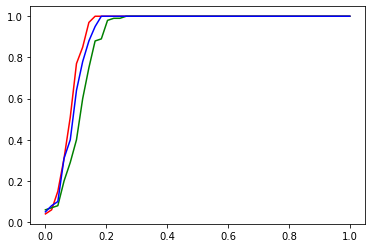

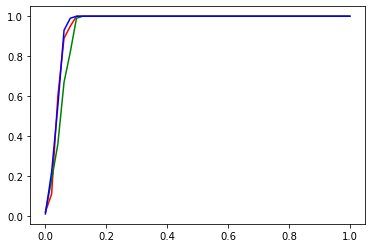

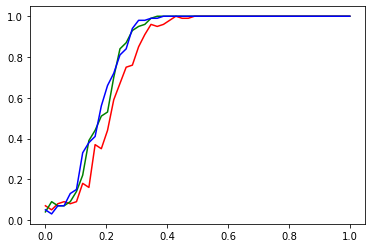

In [9]:
args = np.linspace(0, 1, num=50)

for gen_sample in ((np.vectorize(gen_sample_a), 'a'), (np.vectorize(gen_sample_b), 'b'), (np.vectorize(gen_sample_c), 'c')):
    val_one = [count_false_positive([gen_sample[0](arg) for _ in range(100)], test_one) for arg in args]
    val_two = [count_false_positive([gen_sample[0](arg) for _ in range(100)], test_two) for arg in args]
    val_three = [count_false_positive([gen_sample[0](arg) for _ in range(100)], test_three) for arg in args]
    plt.plot(args, val_one, 'r', args, val_two, 'g', args, val_three, 'b')
    plt.show()

# 2

## (a)
Проверьте с помощью критерия хи-квадрат, принадлежат ли предложенные ниже выборки распределению Пуассона $\Pi_\lambda$ с $\lambda = 4$.
Для этого разбейте вещественную прямую на бины:
$$\{0, 1, 2\}, \{3\}, \{4\}, \{5\}, \{6, 7\}, [8, \infty)$$

Какое распределение имеет статистика критерия (название, не гистограмма) при нулевой гипотезе?

## (b)
Проверьте с помощью критерия хи-квадрат, принадлежат ли предложенные ниже выборки распределению Пуассона $\Pi_\lambda$ с неизвестным $\lambda$. Для этого оцените $\lambda$ из данных (как среднее по выборке)
разбейте вещественную прямую на бины:
$$\{0, 1, 2\}, \{3\}, \{4\}, \{5\}, \{6, 7\}, [8, \infty)$$
Какое распределение имеет статистика критерия (название, не
гистограмма) при нулевой гипотезе?

In [10]:
sample_2a = {3 : 25, 4 : 23, 5 : 13, 2 : 12, 7 : 8, 6 : 6, 8 : 5, 9 : 3, 1 : 3, 10 : 1, 0 : 1}
sample_2b = {2 : 18, 4 : 16, 3 : 15, 5 : 14, 6 : 11, 8 : 8, 7 : 8, 1 : 4, 9 : 3, 0 : 2, 10 : 1}
sample_2c = {4 : 29, 2 : 15, 6 : 15, 3 : 13, 1 : 11, 5 : 10, 8 : 3, 7 : 3, 0 : 1}

In [11]:
def bin_sample(s):
    return np.array([s[0] + s[1] + s[2], s[3], s[4], s[5], s[6] + s[7], sum([s[i] if i > 7 else 0 for i in s.keys()])])

bin_sample_2a = bin_sample(sample_2a)
bin_sample_2b = bin_sample(sample_2b)
bin_sample_2c = bin_sample(sample_2c)

In [12]:
from scipy.stats import poisson

def xi_squared(ps, ns):
    return ((ns - ns.sum() * ps) ** 2 / (ns.sum() * ps)).sum()

def binned_poisson(lambd):
    return np.array([poisson.pmf(0, lambd) + poisson.pmf(1, lambd) + poisson.pmf(2, lambd), poisson.pmf(3, lambd), poisson.pmf(4, lambd), poisson.pmf(5, lambd), poisson.pmf(6, lambd) + poisson.pmf(7, lambd), 1. - poisson.cdf(7, lambd)])

In [13]:
xi_squared(binned_poisson(4), bin_sample_2a), xi_squared(binned_poisson(4), bin_sample_2b), xi_squared(binned_poisson(4), bin_sample_2c)

(8.444342764922272, 11.561246364609007, 10.260852872397093)

In [14]:
def sample_mean(sel):
    return sum([sel[k] * k for k in sel.keys()]) / sum(sel.values())

lambda_a = sample_mean(sample_2a)
lambda_b = sample_mean(sample_2b)
lambda_c = sample_mean(sample_2c)

In [15]:
xia, xib, xic = xi_squared(binned_poisson(lambda_a), bin_sample_2a), xi_squared(binned_poisson(lambda_b), bin_sample_2b), xi_squared(binned_poisson(lambda_c), bin_sample_2c)

xia, xib, xic

(6.8268043269421215, 5.189205155994414, 10.062814072256842)

In [16]:
from scipy.stats import chi2

chi2.cdf(xia, df=5), chi2.cdf(xib, df=5), chi2.cdf(xic, df=5)

(0.7661569597709076, 0.6067713814388382, 0.9265251235532614)

In [17]:
np.array([sample_2a[0] + sample_2a[1], sum(sample_2a.values()) - sample_2a[0] - sample_2a[1]])

array([ 4, 96])

In [18]:
def wtf_xi(sample):
    lambd = sample_mean(sample)
    ns2a = np.array([sample[0] + sample[1], sum(sample.values()) - sample[0] - sample[1]])
    ps2a = np.array([poisson.pmf(0, lambd) + poisson.pmf(1, lambd), 1 - poisson.pmf(0, lambd) + poisson.pmf(1, lambd)])

    return ((ns2a - ns2a.sum() * ps2a) ** 2 / (ns2a.sum() * ps2a)).sum()

wtf_xi(sample_2a), wtf_xi(sample_2b), wtf_xi(sample_2c)

(2.195734445403083, 1.0246895269903575, 3.2966774803488534)

# 3

In [19]:
import pandas as pd

isit = pd.read_csv('isitgauss.csv')['y'].to_numpy()

isit.min(), isit.max()

(-2.9999956593182, 2.99989221418179)

(array([ 245,  453,  890, 1483, 3844, 1483,  913,  450,  239]),
 array([0.02275013, 0.04405707, 0.09184805, 0.14988228, 0.38292492,
        0.14988228, 0.09184805, 0.04405707, 0.02275013]),
 3.7863248262363163)

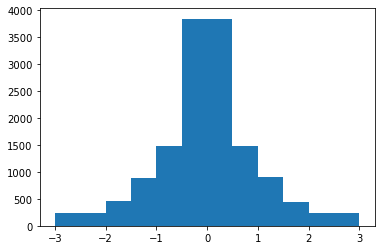

In [20]:
from scipy.stats import norm

ps_gauss = np.array([norm.cdf(-2), norm.cdf(-1.5) - norm.cdf(-2), norm.cdf(-1) - norm.cdf(-1.5), norm.cdf(-0.5) - norm.cdf(-1), norm.cdf(0.5) - norm.cdf(-0.5), norm.cdf(1) - norm.cdf(0.5), norm.cdf(1.5) - norm.cdf(1), norm.cdf(2) - norm.cdf(1.5), 1. - norm.cdf(2)])

binned_float, _, _ = plt.hist(isit, bins=[-3, -2, -1.5, -1, -0.5, 0.5, 1, 1.5, 2, 3])

binned_int = binned_float.astype(int)

binned_int, ps_gauss, xi_squared(ps_gauss, binned_int)

# 4

In [21]:
df = pd.read_csv('onesnp.csv')

df.head()

,C,1
0,G,0
1,G,0
2,T,1
3,G,0
4,G,1


In [22]:
arr = {'A':[1224, 1199], 'C': [1259, 1266], 'G': [1286, 1253], 'T': [1237, 1276]}

for nuc, vals in arr.items():
    print(nuc, 0, vals[0], 1, vals[1])

A 0 1224 1 1199
C 0 1259 1 1266
G 0 1286 1 1253
T 0 1237 1 1276
